In [1]:
#basic
import os
import pickle
import time
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import joblib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide tf warnings
#tensorflow and keras
# import tensorflow
# from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout, Resizing, Rescaling, RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras import Model
# from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras.models import load_model

#sklearn
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

#open cv
import cv2 as cv

from cascid.models.StackedModel import StackedModel
from cascid.configs.config import DATA_DIR
from cascid.configs.pad_ufes_cnf import PAD_UFES_DIR
from cascid.datasets.pad_ufes import database as pad_ufes
from cascid.datasets.isic import database as isic

RANDOM_STATE = 42
NN_PATH = DATA_DIR / 'dip' / 'model_resnet34_isic_noreg_aug_raw_rescaling'
RFC_PATH = PAD_UFES_DIR / 'rfc_clf_bin_final.joblib'

In [2]:
rfc = joblib.load(RFC_PATH)
NN = load_model(NN_PATH)

In [4]:
x_train_metadata, x_train_stacked, x_test, y_train_metadata, y_train_stacked, y_test = pad_ufes.get_train_test_metadata(return_img_id=True)

In [7]:
x_train_nn = x_train_stacked['img_id'].to_numpy()
x_train_rfc = x_train_stacked.drop('img_id', axis=1).to_numpy().astype(np.float64)

x_test_nn = x_test['img_id'].to_numpy()
x_test_rfc = x_test.drop('img_id', axis=1).to_numpy().astype(np.float64)

In [6]:
StackModel = StackedModel(NN, rfc)

StackModel.fit(x_train_nn, x_train_rfc, y_train_stacked)

# preds = StackModel.predict(x_test, x_test_rfc)

# preds

18/18 [==============================] - 2s 26ms/step


In [8]:
preds_train = StackModel.predict(x_train_nn, x_train_rfc)
preds_test = StackModel.predict(x_test_nn, x_test_rfc)

9/9 [==============================] - 0s 37ms/step


In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

<AxesSubplot:title={'center':'Train'}, xlabel='Predicted label', ylabel='True label'>

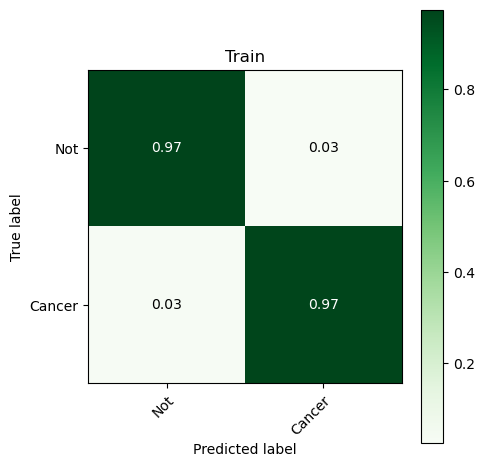

In [12]:
plot_confusion_matrix(y_train_stacked, preds_train, ["Not", "Cancer"], title="Train")

<AxesSubplot:title={'center':'Test'}, xlabel='Predicted label', ylabel='True label'>

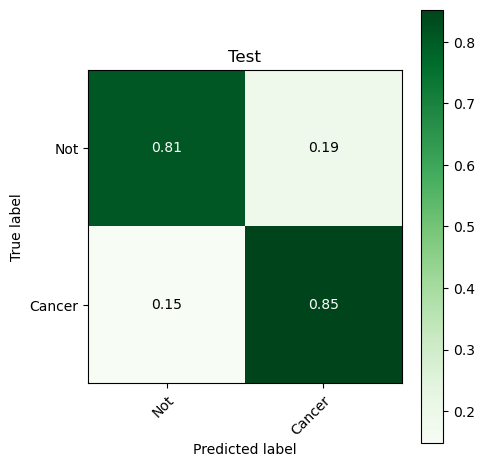

: 

In [13]:
plot_confusion_matrix(y_test, preds_test, ["Not", "Cancer"], title="Test")

In [ ]:
# accuracy_score(y_true=y_test, y_pred=preds)